In [1]:
''' required import '''

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import pytesseract

In [36]:
''' some useful function '''

def noiseReducer(img):
    img = np.array(img)
    img = cv2.GaussianBlur(img, (7, 7), 0)
    img = Image.fromarray(img, 'RGB')
    
    return img

def polarCoordinateToLinearEquation(rho, theta, width, height):
    a0 = np.cos(theta)
    b0 = np.sin(theta)
    if a0 == 0: # y = rho
        X1 = 0
        Y1 = rho
        X2 = width
        Y2 = rho
    elif b0 == 0: # x = rho
        X1 = rho
        Y1 = 0
        X2 = rho
        Y2 = height
    else: # y = ax + b
        Xa = a0*rho
        Ya = b0*rho
        Xb = Xa+b0
        Yb = Ya-a0
        a = -a0/b0
        b = Ya - a*Xa
        x1 = -b/a
        y1 = 0
        x2 = (height-b)/a
        y2 = height
        x3 = 0
        y3 = b
        x4 = width
        y4 = a*width + b
        solution = []
        if 0<=x1 and x1<=width:
            solution.append((x1,y1))
        if 0<=x2 and x2<=width:
            solution.append((x2,y2))
        if 0<=y3 and y3<=height:
            solution.append((x3,y3))
        if 0<=y4 and y4<=height:
            solution.append((x4,y4))
        X1,Y1 = solution[0]
        X2,Y2 = solution[1]
    X1 = int(X1)
    Y1 = int(Y1)
    X2 = int(X2)
    Y2 = int(Y2)
    
    return X1, Y1, X2, Y2

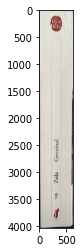

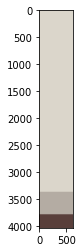

[219.52548 214.18712 203.1503 ]


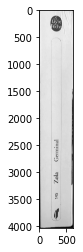

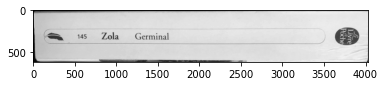

 
     
 

Zola

Germinal



In [40]:
''' book spine processing '''

# constraint :
# doesn't work with book spine containing picture
# it's much better if the color is uniform

# image load
img = Image.open('../image/bookSpine/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)


"""
img : image of a book spine OR scrap image
return : book's information

note : should return anything for scrap image and don't lose time for them
"""
def bookSpineProcessing(img):
    
    width, height = img.size
    img = np.array(img)
    
    # k-means clustering
    pixels = np.float32(img.reshape(-1, 3))
    n_colors = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    dominant = palette[np.argmax(counts)]
    
    # color 
    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    rows = np.int_(img.shape[0]*freqs)
    dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
    plt.imshow(dom_patch)
    plt.show()
    print(dominant)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # binarisation
    # binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # noise reducer
    img = cv2.GaussianBlur(gray, (3, 3), 0)
    img = Image.fromarray(gray)
    
    # rotation
    rotate = img.rotate(-90, expand = 1)
    plt.imshow(rotate, cmap='gray')
    plt.show()
    
    # OCR
    text = pytesseract.image_to_string(rotate)
    print(text)
    
    return None # work in progress...

# show result
bookSpineProcessing(img)

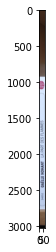

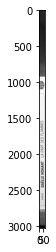

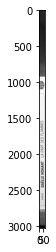

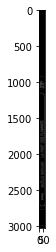

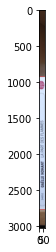

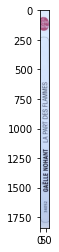

In [16]:
''' book spine extraction '''

# constraint :
# nothing for now

# image load
img = Image.open('../image/noisyBookSpine/3')
plt.imshow(img)
plt.show()


"""
img : image of a noisy book spine
return : list of book spine
"""
def bookSpineExtraction(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    #gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 10, 100)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    threshold = width//2
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    if lines is None:
        lines = [[]]
    coordinate.append((0,0))
    for line in lines:
        for rho,theta in line:
            if np.pi/2-0.01<theta and theta<np.pi/2+0.01:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((y1,y2))
    coordinate.append((height,height))
    plt.imshow(houghTransform)
    plt.show()
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = height//10
    for y1,y2 in coordinate:
        if (last != None and last<min(y1,y2)-threshold):
            # crop
            im = img.crop((0, last, width, max(y1,y2)))
            w,h = im.size
            # add it
            croppedImg.append((h,im))
        last = min(y1,y2)
    croppedImg.sort(reverse=True, key = lambda x: x[0])
    i, img = croppedImg[0]
    return img

img = bookSpineExtraction(img)
plt.imshow(img)
plt.show()

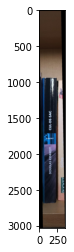

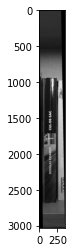

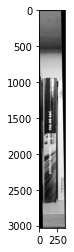

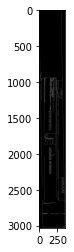

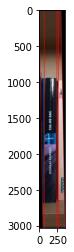

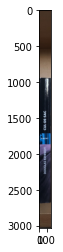

In [17]:
''' row segmentation lvl2 '''

# constraint :
# nothing for now

# image load
img = Image.open('../image/noisyBookSpine/9')
plt.imshow(img)
plt.show()


"""
img : image of a noisy book spine
return : list of book spine
"""
def rowSegmentation2(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = ( cv2.HoughLines(edges, 1, np.pi/180, threshold))
    if lines is None:
        lines = [[]]
    coordinate.append((0,0))
    for line in lines:
        for rho,theta in line:
            if theta<np.pi/2-0.3 or np.pi/2+0.3<theta:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((x1,x2))
    coordinate.append((width,width))
    plt.imshow(houghTransform)
    plt.show()
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = width//5
    for x1,x2 in coordinate:
        if (last != None and last<min(x1,x2)-threshold):
            # crop
            im = img.crop((last, 0, max(x1,x2), height))
            # add it
            croppedImg.append(im)
        last = min(x1,x2)
        
    return croppedImg

images = rowSegmentation2(img)
for im in images:
    plt.imshow(im)
    plt.show()

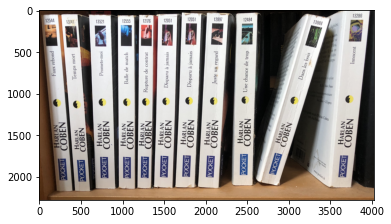

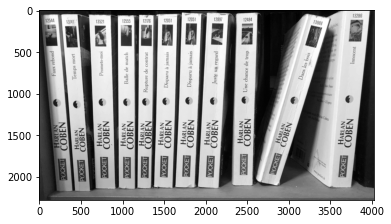

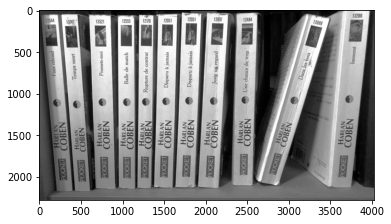

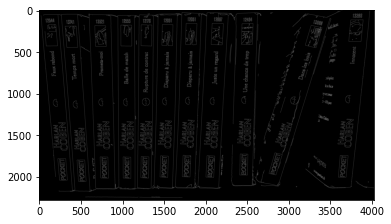

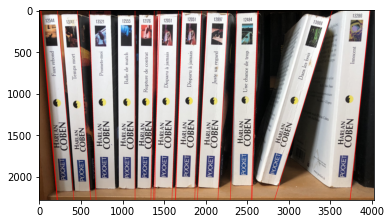

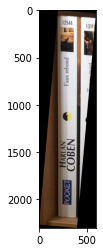

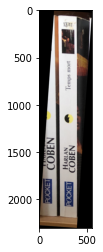

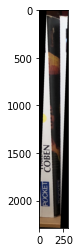

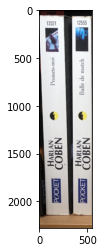

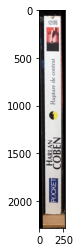

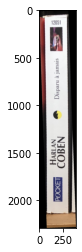

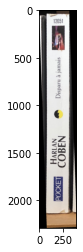

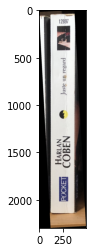

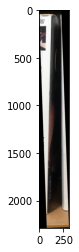

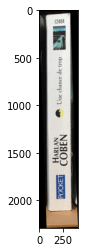

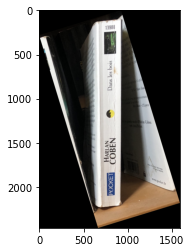

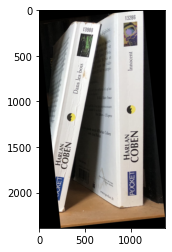

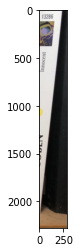

In [30]:
''' row segmentation lvl1 '''

# constraint : 
# doesn't work with thin book spines
# doesn't work with horizontal book spines
# only book spines should apear

# image load
img = Image.open('../image/bookRow/7.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

"""
img : image of a book row
return : list of noisy book spines
"""
def rowSegmentation1(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    if lines is None:
        lines = [[]]
    coordinate.append((0,0,0))
    for line in lines:
        for rho,theta in line:
            if theta<np.pi/2-0.3 or np.pi/2+0.3<theta:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((x1,x2,theta))
    coordinate.append((width,width,0))
    plt.imshow(houghTransform)
    plt.show()
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = width/50
    for x1,x2,theta in coordinate:
        if (last != None and last<min(x1,x2)-threshold):
            # crop
            im = img.crop((last, 0, max(x1,x2), height))
            # rotate
            theta = math.degrees(theta)
            if theta>90:
                theta = theta-180
            else:
                theta = theta
            im = im.rotate(theta, expand = 1)
            # add it
            croppedImg.append(im)
        last = min(x1,x2)
    
    return croppedImg

# show result
images = rowSegmentation1(img)
for im in images:
    plt.imshow(im)
    plt.show()

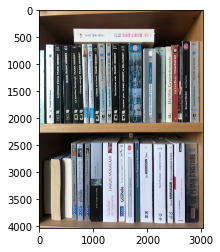

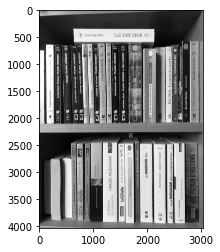

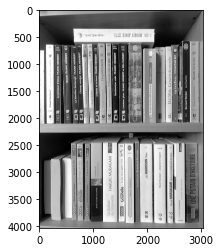

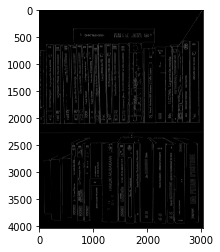

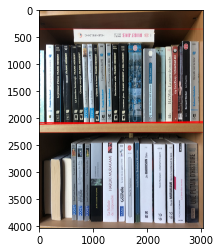

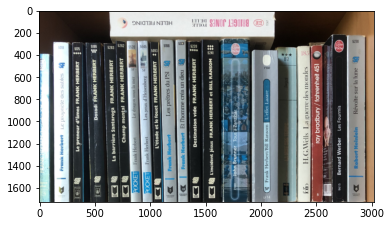

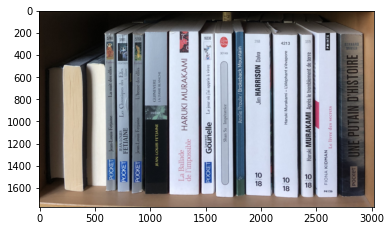

In [19]:
''' bookshelf segmentation '''

# constraint : 
# doesn't work with thin book spines 
# doesn't work with low definition image

# image load
img = Image.open('../image//bookshelf/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)


"""
img : image of a vertical bookshelf
return : list of book rows
"""
def bookshelfSegmentation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.Canny(gray, 50, 200)
    plt.imshow(edges, cmap='gray')
    plt.show()

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    if lines is None:
        lines = [[]]
    coordinate.append(0)
    for line in lines:
        for rho,theta in line:
            if np.pi/2-0.1<theta and theta<np.pi/2+0.1:
                x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((y1+y2)//2)
    coordinate.append(height)
    plt.imshow(houghTransform)
    plt.show()

    # crop image
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = height/10
    for y in coordinate:
        if (last != None and last<y-threshold):
            croppedImg.append(img.crop((0, last, width, y)))
        last = y
    
    return croppedImg

# show result
images = bookshelfSegmentation(img)
for im in images:
    plt.imshow(im)
    plt.show()

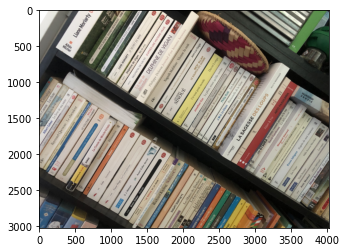

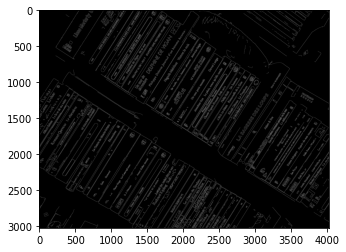

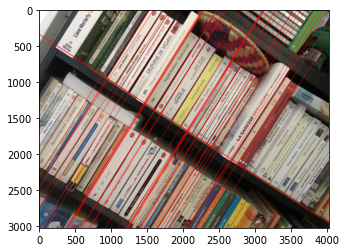

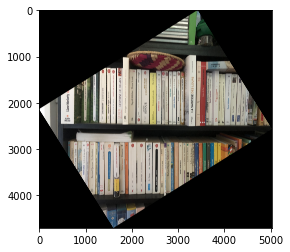

In [20]:
''' bookshelf orientation '''

# constraint : 
# the majority of the books must be well oriented
# the image should not be too askew

# image load
img = Image.open('../image/askewBookshelf/1.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

"""
img : askew image of bookshelf
return : reoriented image
"""
def bookshelfOrientation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    treshold = 500
    lines = cv2.HoughLines(edges, 1, np.pi/180, treshold)
    length = max(width, height)
    angles = []
    houghTransform = img.copy()
    if lines is None:
        lines = [[]]
    for line in lines:
        for rho,theta in line:
            x1, y1, x2, y2 = polarCoordinateToLinearEquation(rho, theta, width, height)
            houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
            angles.append(theta)
    plt.imshow(houghTransform)
    plt.show()
    
    # orientation
    angles.sort()
    theta = angles[len(angles)//2]
    theta = math.degrees(theta)
    if theta>90:
        theta = theta - 180
    img = Image.fromarray(img, 'RGB')
    img = img.rotate(theta, expand = 1)
    
    return img

# show result
img = bookshelfOrientation(img)
plt.imshow(img)
plt.show()

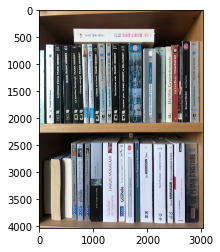

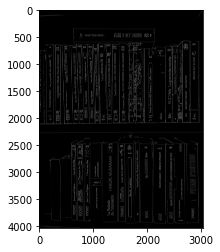

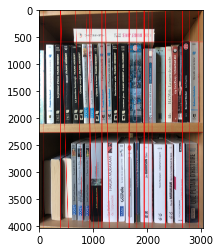

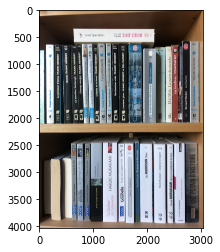

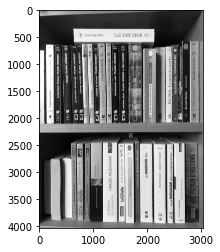

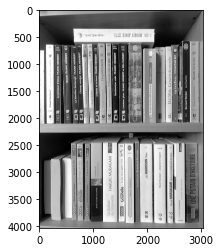

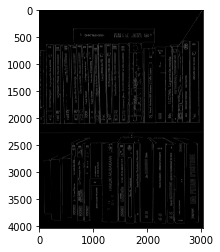

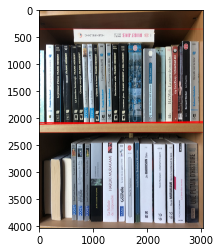

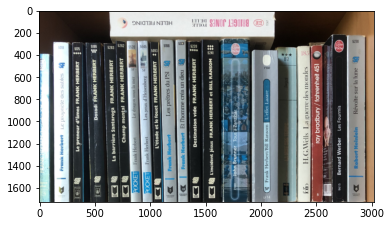

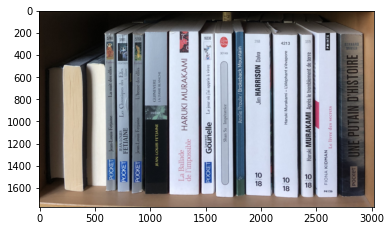

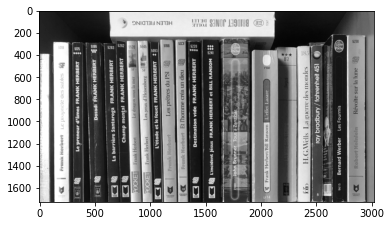

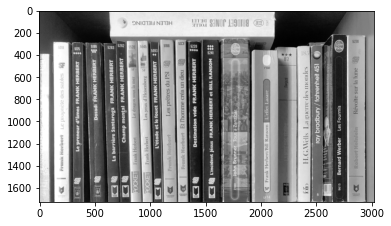

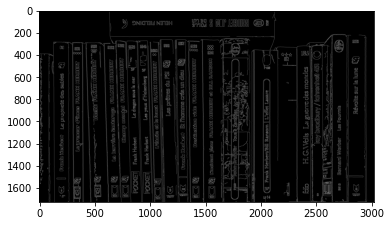

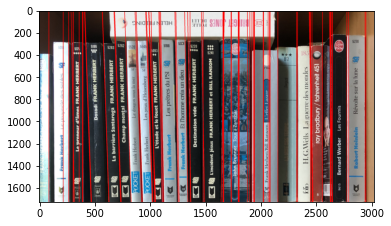

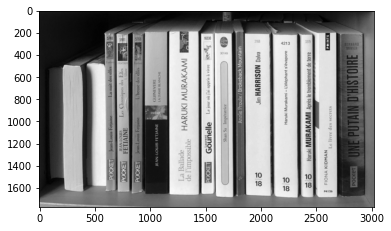

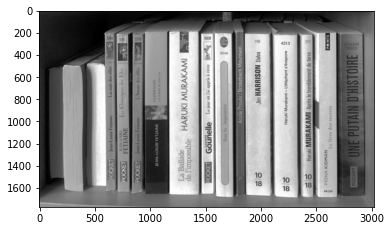

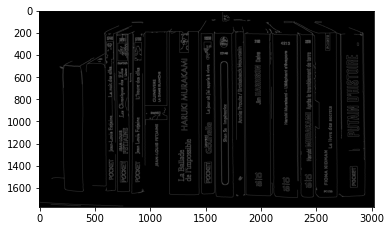

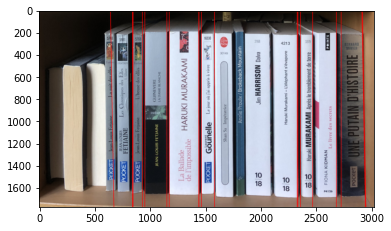

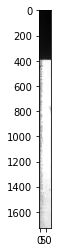

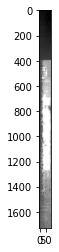

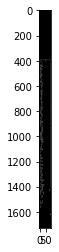

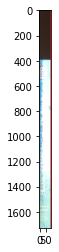

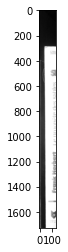

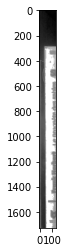

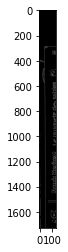

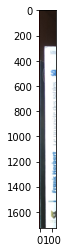

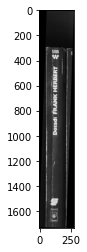

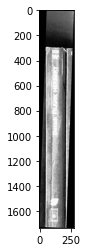

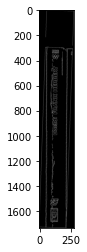

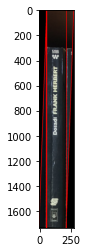

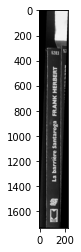

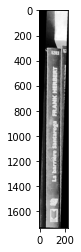

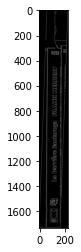

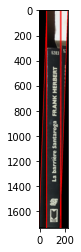

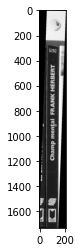

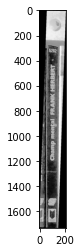

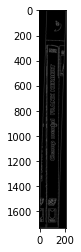

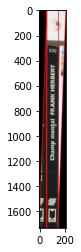

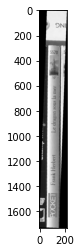

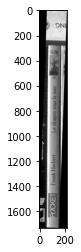

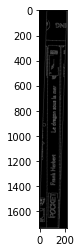

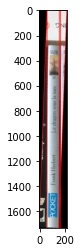

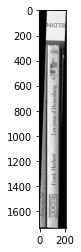

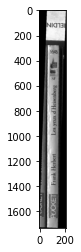

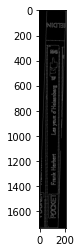

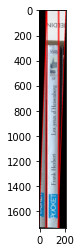

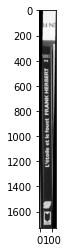

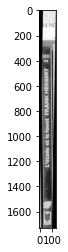

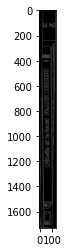

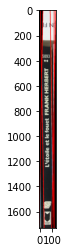

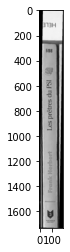

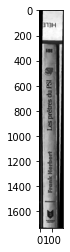

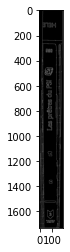

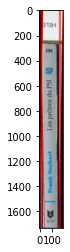

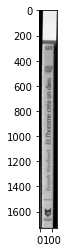

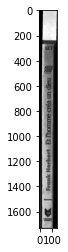

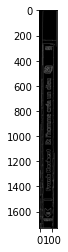

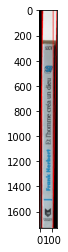

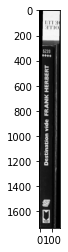

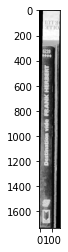

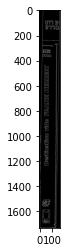

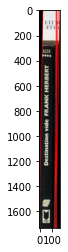

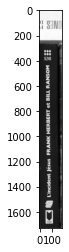

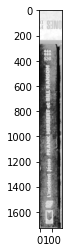

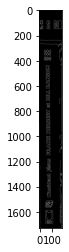

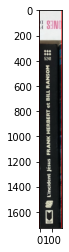

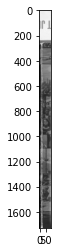

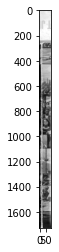

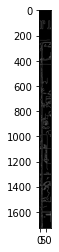

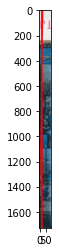

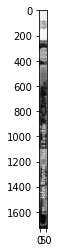

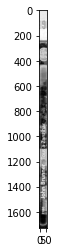

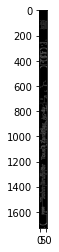

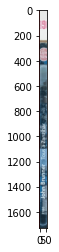

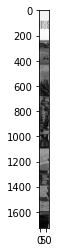

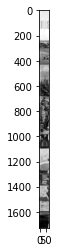

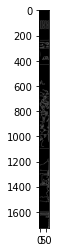

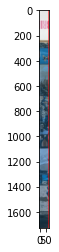

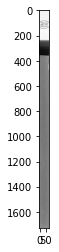

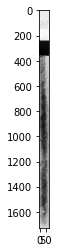

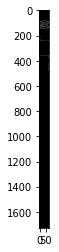

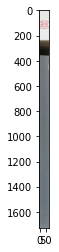

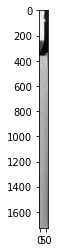

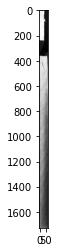

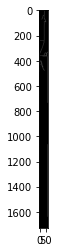

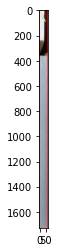

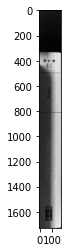

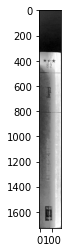

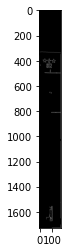

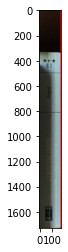

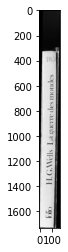

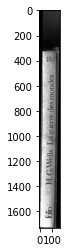

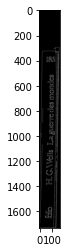

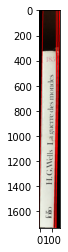

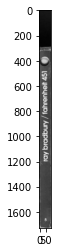

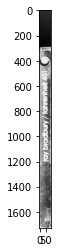

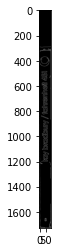

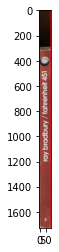

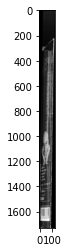

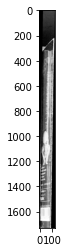

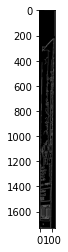

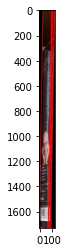

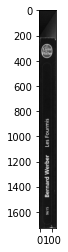

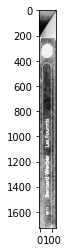

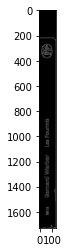

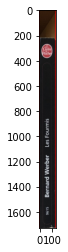

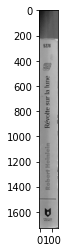

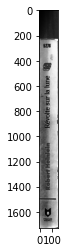

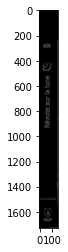

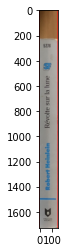

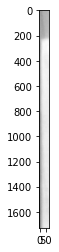

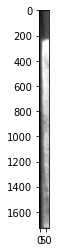

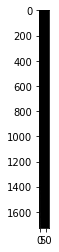

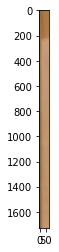

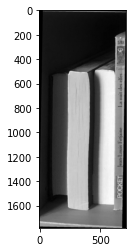

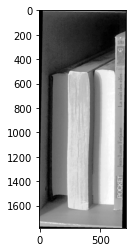

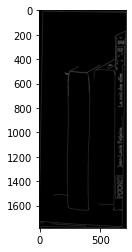

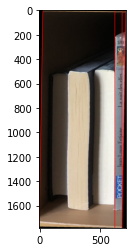

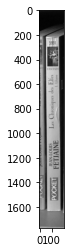

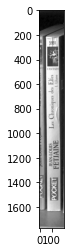

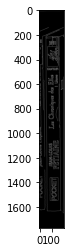

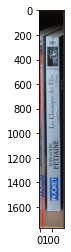

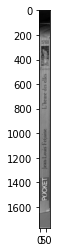

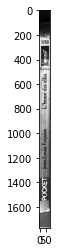

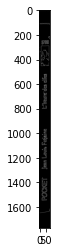

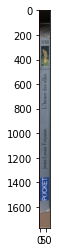

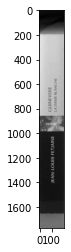

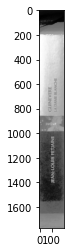

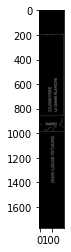

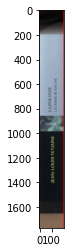

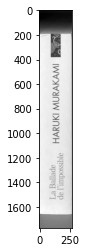

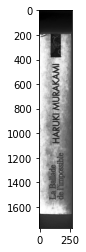

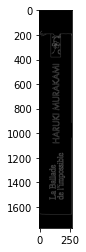

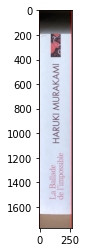

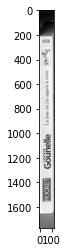

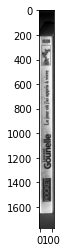

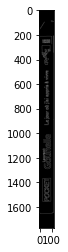

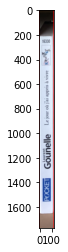

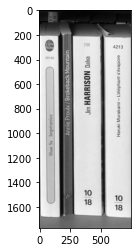

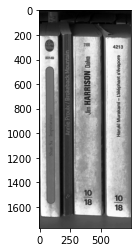

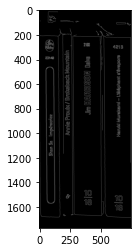

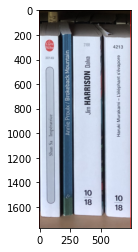

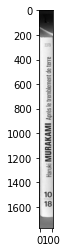

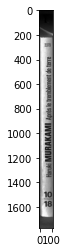

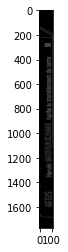

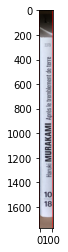

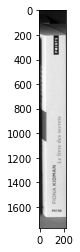

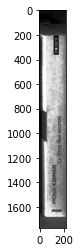

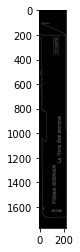

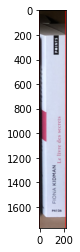

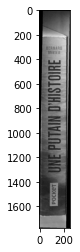

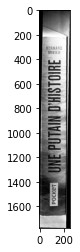

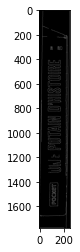

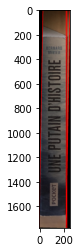

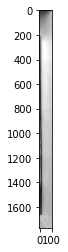

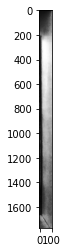

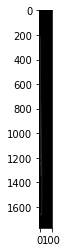

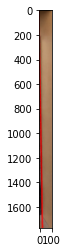

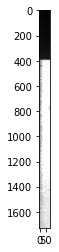

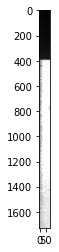

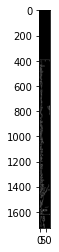

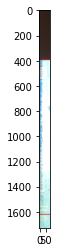

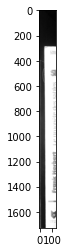

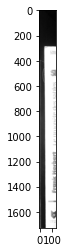

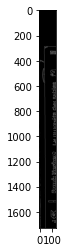

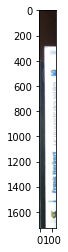

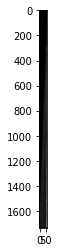

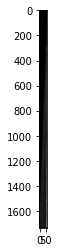

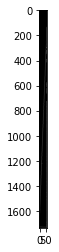

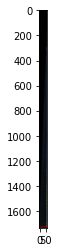

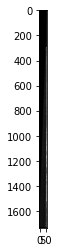

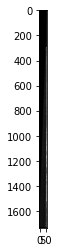

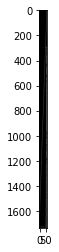

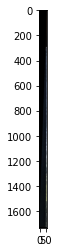

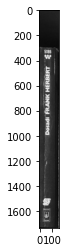

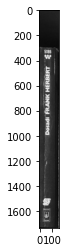

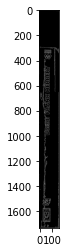

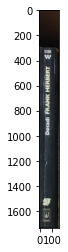

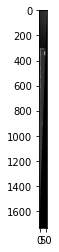

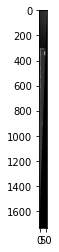

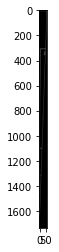

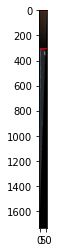

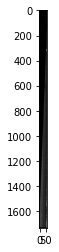

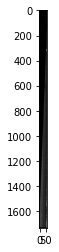

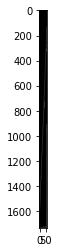

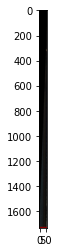

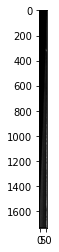

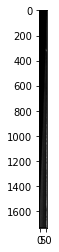

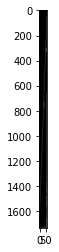

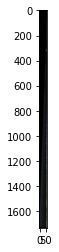

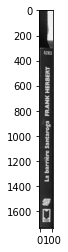

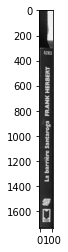

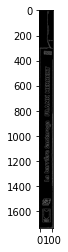

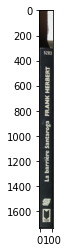

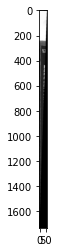

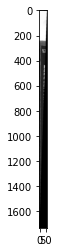

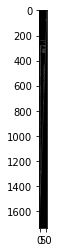

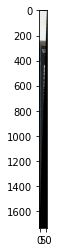

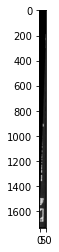

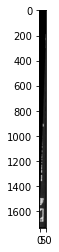

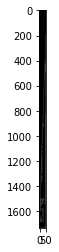

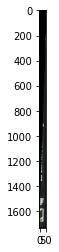

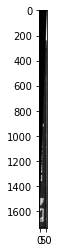

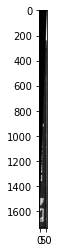

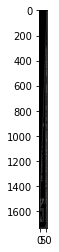

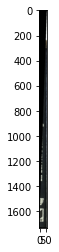

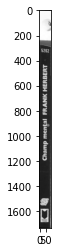

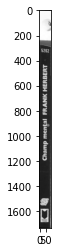

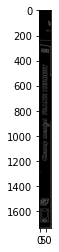

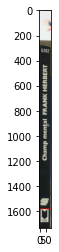

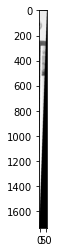

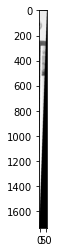

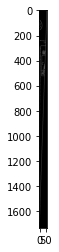

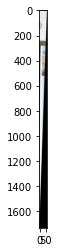

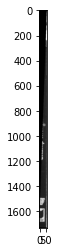

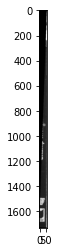

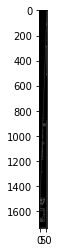

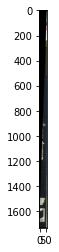

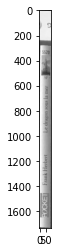

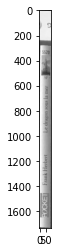

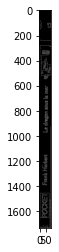

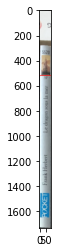

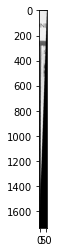

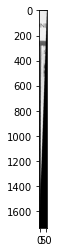

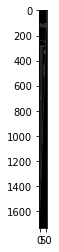

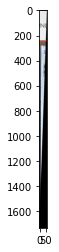

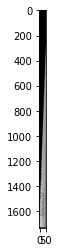

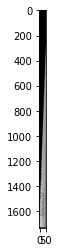

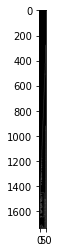

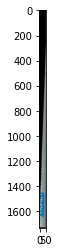

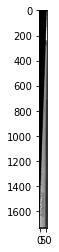

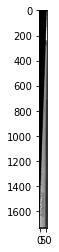

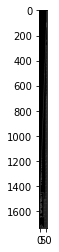

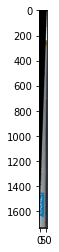

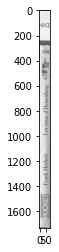

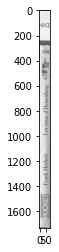

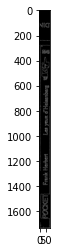

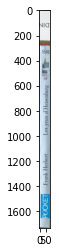

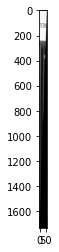

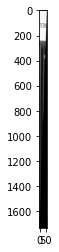

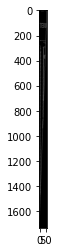

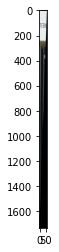

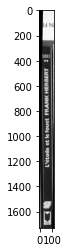

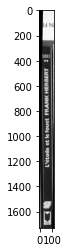

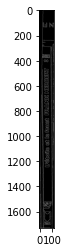

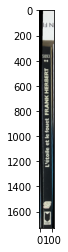

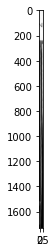

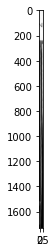

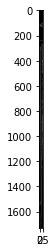

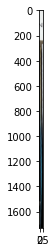

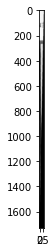

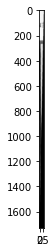

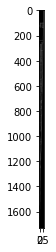

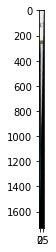

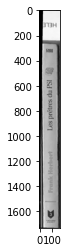

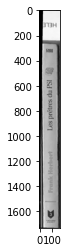

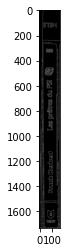

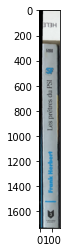

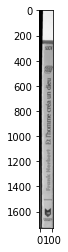

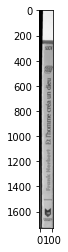

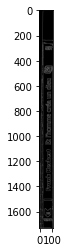

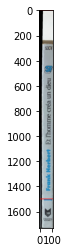

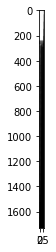

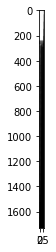

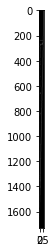

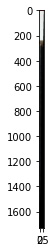

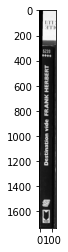

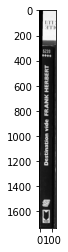

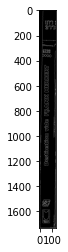

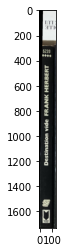

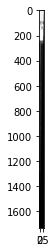

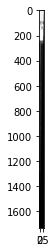

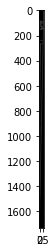

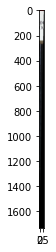

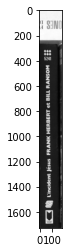

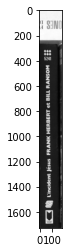

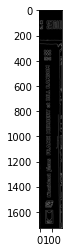

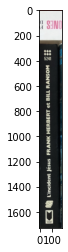

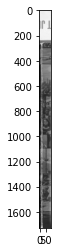

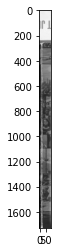

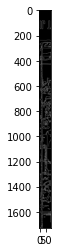

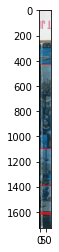

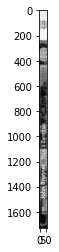

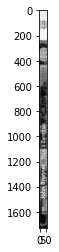

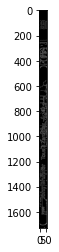

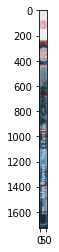

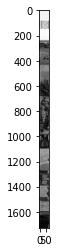

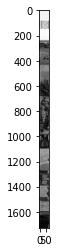

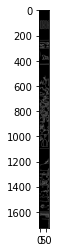

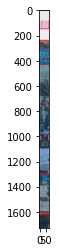

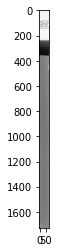

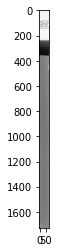

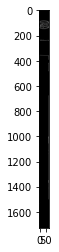

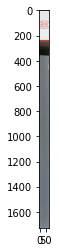

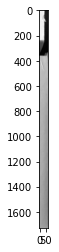

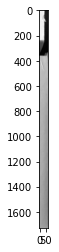

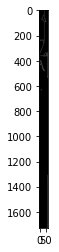

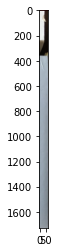

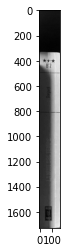

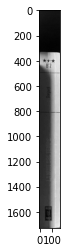

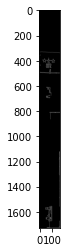

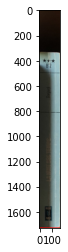

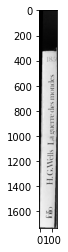

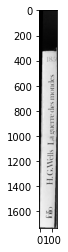

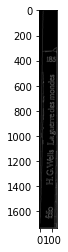

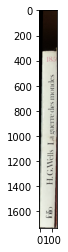

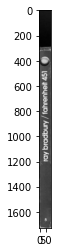

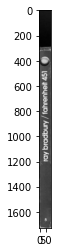

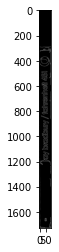

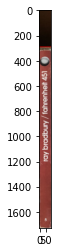

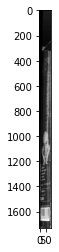

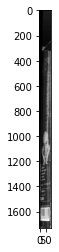

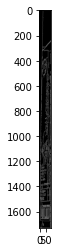

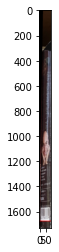

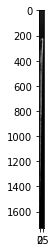

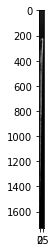

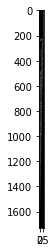

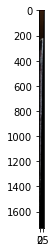

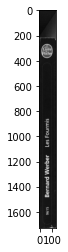

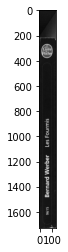

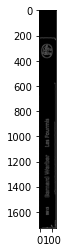

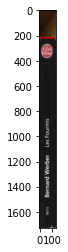

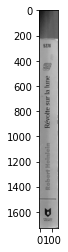

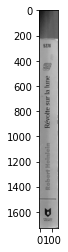

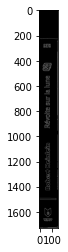

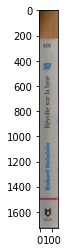

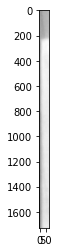

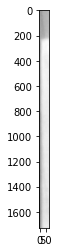

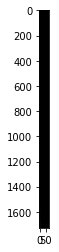

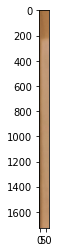

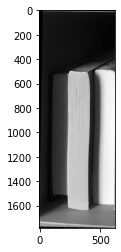

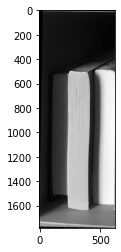

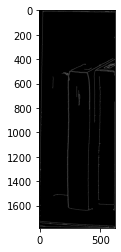

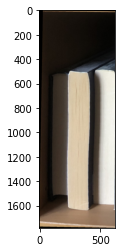

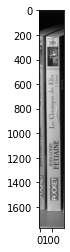

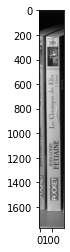

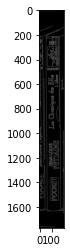

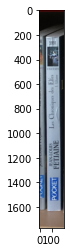

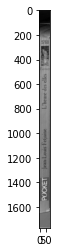

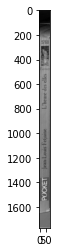

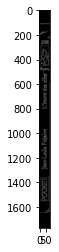

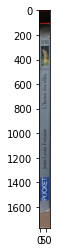

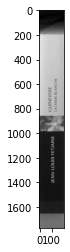

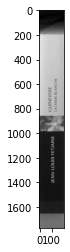

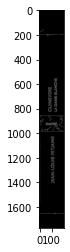

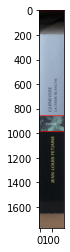

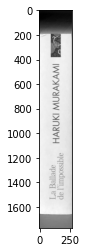

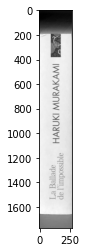

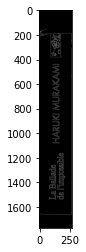

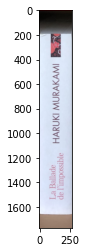

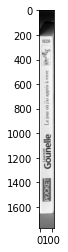

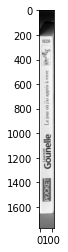

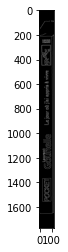

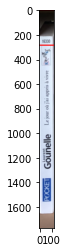

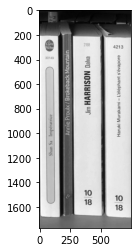

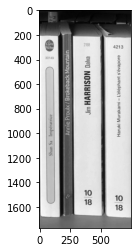

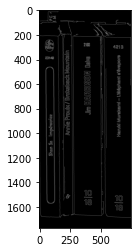

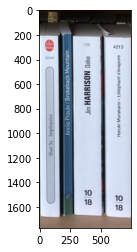

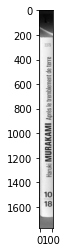

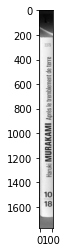

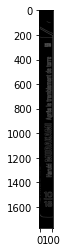

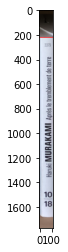

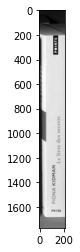

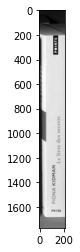

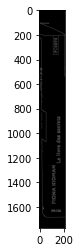

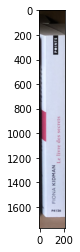

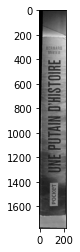

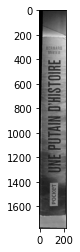

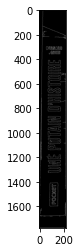

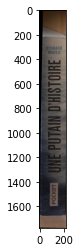

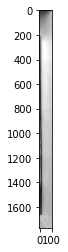

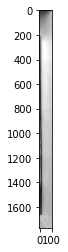

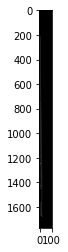

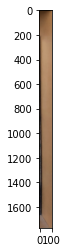

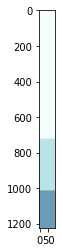

[245.08517 253.85405 253.72015]


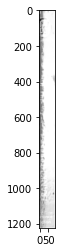

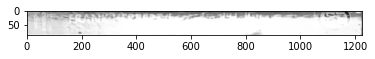

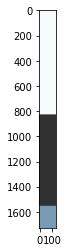

[248.78465 251.36858 252.1975 ]


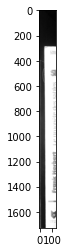

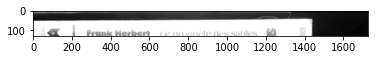

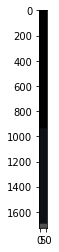

[0.00183431 0.00215251 0.00245199]


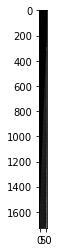

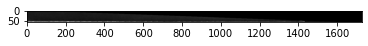

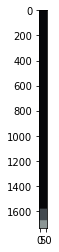

[ 6.0210104  7.9098606 10.666908 ]


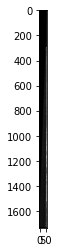

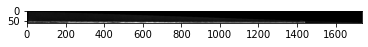

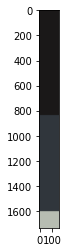

[26.510735 24.733677 24.26208 ]


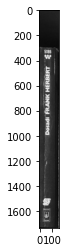

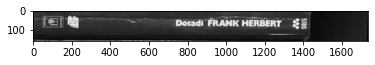

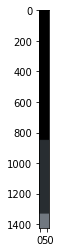

[0.34370968 0.34131658 0.5794866 ]


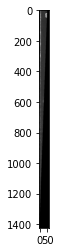

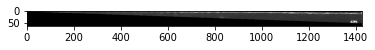

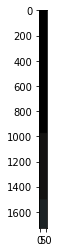

[0.29143175 0.29737568 0.32695112]


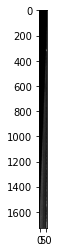

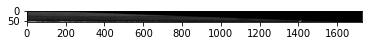

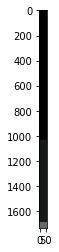

[1.2743341 1.2385662 1.4609283]


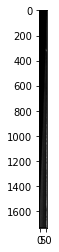

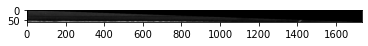

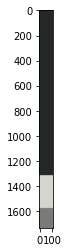

[36.828144 39.305573 40.3123  ]


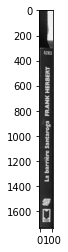

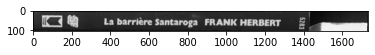

ea 2) Pe



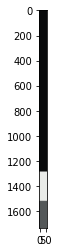

[ 9.821963 10.80213  11.827919]


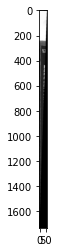

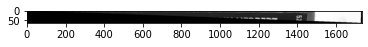

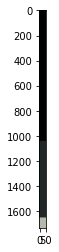

[0.76141614 0.92856646 1.1543357 ]


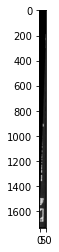

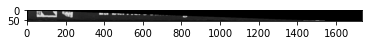

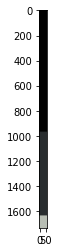

[1.350321  1.6094723 1.9648296]


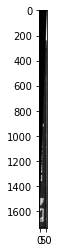

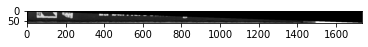

ell ee ee



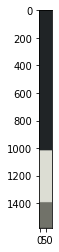

[32.712555 36.42382  38.44642 ]


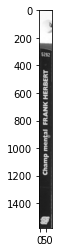

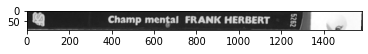

ber Mee itis



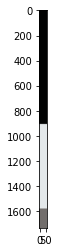

[1.896484  2.1974669 2.8526707]


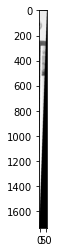

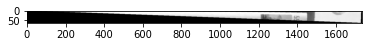

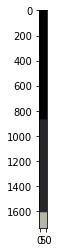

[0. 0. 0.]


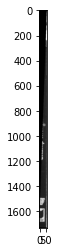

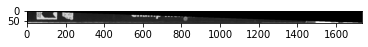

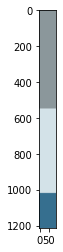

[139.5674  151.12105 155.63289]


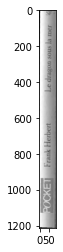

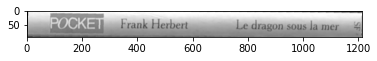

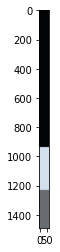

[3.977269  4.0809407 5.081025 ]


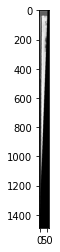

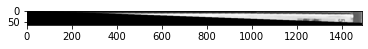

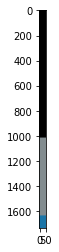

[0.05522484 0.05746189 0.05888375]


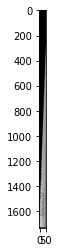

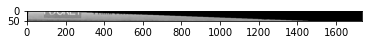

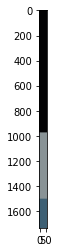

[3.3956366 3.492943  4.3741674]


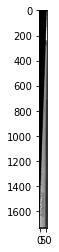

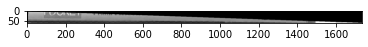

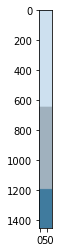

[205.10234 224.76067 239.39703]


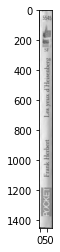

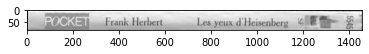

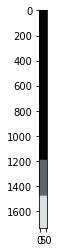

[6.0664015 6.6433253 7.5719295]


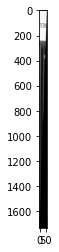

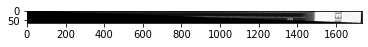

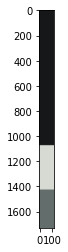

[21.41996  23.952723 25.682005]


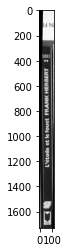

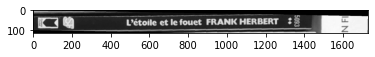

 

at

 

BT asd es

N Fl



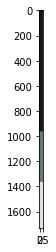

[22.365578 25.876354 28.23486 ]


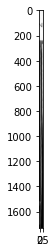

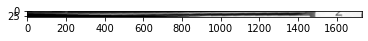

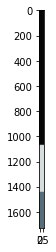

[5.8816485 6.172704  6.6752715]


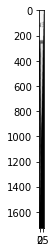

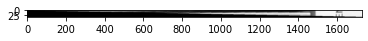

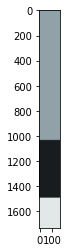

[145.11812 161.76958 168.32683]


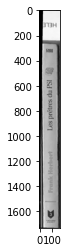

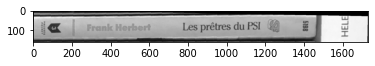

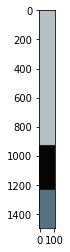

[180.9706  192.39427 196.42932]


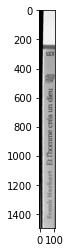

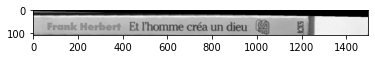

 

Et l'homme créa un dieu (4



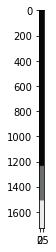

[6.5060444 6.7972684 7.152245 ]


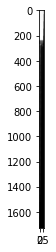

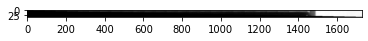

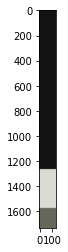

[17.251348 19.319424 20.135912]


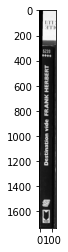

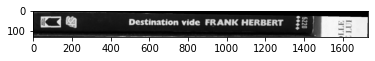

Destination vide FRANK HERBERT



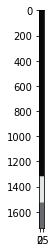

[ 8.592019   9.721516  10.8764105]


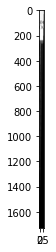

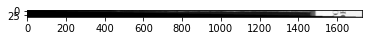

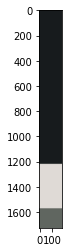

[23.392197 27.579298 29.013807]


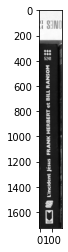

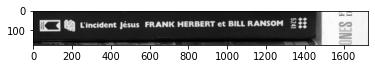

4 &@ Lincident Jésus FRANK HERBERT et BILL RANSOM

Th)

Saad



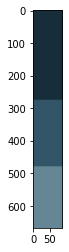

[23.497261 46.62052  58.593693]


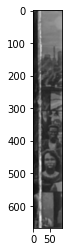

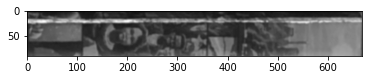

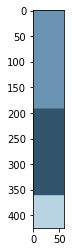

[107.80552 147.51219 178.61874]


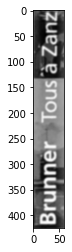

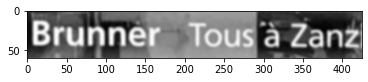

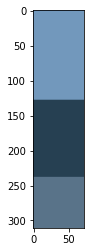

[114.47748 152.93393 188.66081]


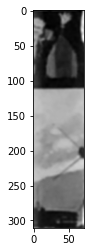

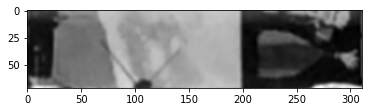

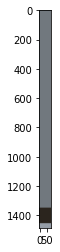

[113.15664  120.741615 126.87948 ]


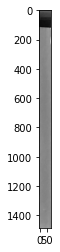

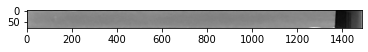

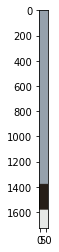

[150.51598 161.70668 172.02133]


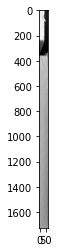

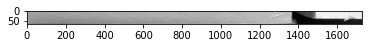

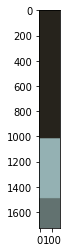

[38.14324  35.541676 28.804722]


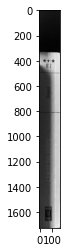

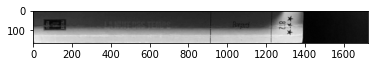

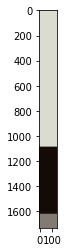

[218.86024 220.57544 208.3983 ]


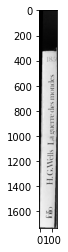

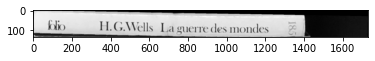

 

lolio H.G.Wells La guerre des mondes



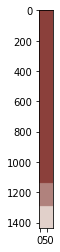

[139.3871    64.918724  59.08997 ]


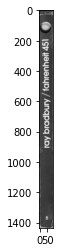

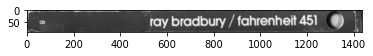

aaa Bd PAC Se ma



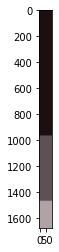

[27.074348 16.916689 15.333471]


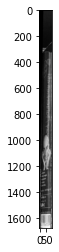

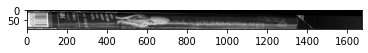

PRLS ore ae



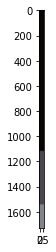

[8.896677  5.418473  3.3915367]


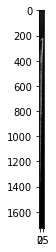

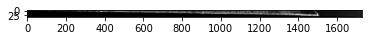

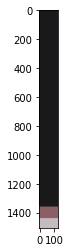

[25.352661 24.999678 26.974783]


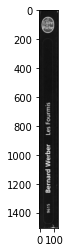

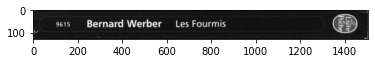

9615 Bernard Werber Les Fourmis



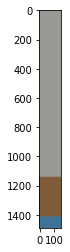

[154.9514  153.30373 149.04893]


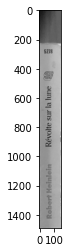

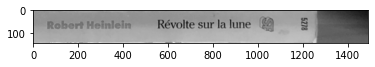

RobertHeinlein -Révoltesurlalune @ §& ——_



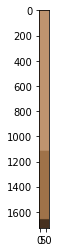

[190.51108 148.7922  111.18065]


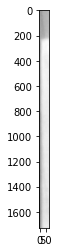

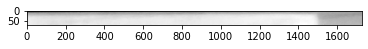

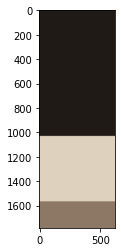

[31.958353 26.08689  21.030703]


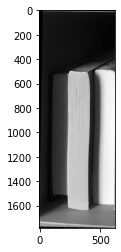

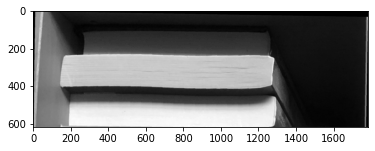

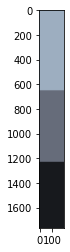

[157.25606 174.35176 192.48216]


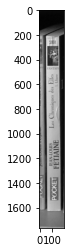

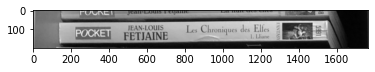

JEAN-LOUIS PF CUualhe bsG FEMME LED O VEEL {tld co

re JEAN LOUIS . | aaa Col 5 | 2
ON SE EE

  
 
    
 

 



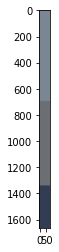

[123.276054 134.98564  147.7621  ]


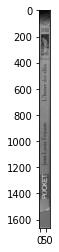

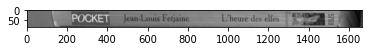

\

POCK|

Jean-Louis Feyaine

Vheure des elfes > == = a



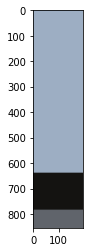

[157.44234 174.9633  195.76996]


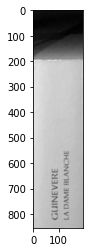

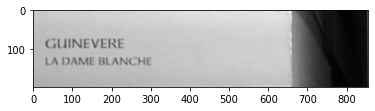

GUINEVERE

LA DAME BLANCHI



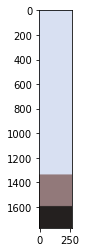

[216.19225 224.41629 242.49841]


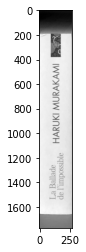

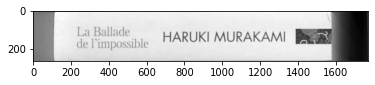

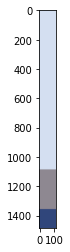

[212.28076 223.31627 241.2587 ]


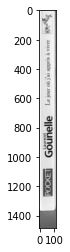

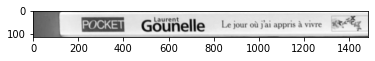

 

| POCKE Gounelle Le jour oi j'ai appris a vivre akg



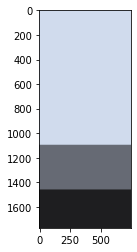

[208.51277 219.1569  237.42116]


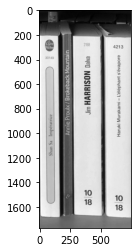

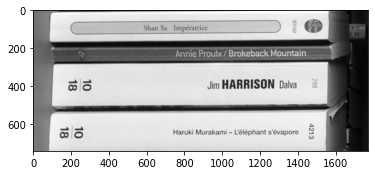

Jim HARRISON Dalva

Haruki Murakami - L’éléphant s’évapore

 



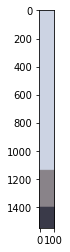

[204.25136 211.94522 227.43896]


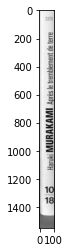

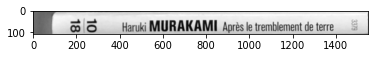

 

. 21O Haruki MURAKAMI Apres |e tremblement de terre =



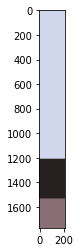

[208.00636 215.06001 236.2935 ]


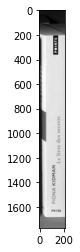

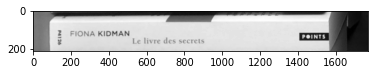

y
ot
yD
>

FIONA KIDMAN

Le livre des secrets

 



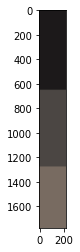

[28.219229 25.316942 26.989315]


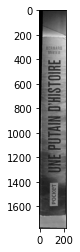

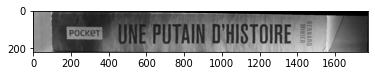

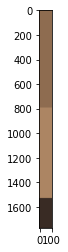

[142.64908  108.3816    80.044304]


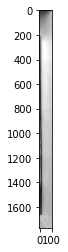

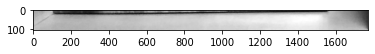

In [41]:
''' all process '''

# image load
img = Image.open('../image/bookshelf/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

# orientation
reoriented = bookshelfOrientation(img)
plt.imshow(reoriented)
plt.show()

# bookshelf segmentation
rows = bookshelfSegmentation(reoriented)
for im in rows:
    plt.imshow(im)
    plt.show()

# row segmentation 1
row1 = []
for im in rows:
    spines = rowSegmentation1(im)
    row1 = row1 + spines
    
# row segmentation 2
row2 = []
for im in row1:
    spines = rowSegmentation2(im)
    row2 = row2 + spines

# spine extraction
bookSpine = []
for im in row2:
    bookSpine.append(bookSpineExtraction(im))

# book spine processing
for book in bookSpine:
    bookSpineProcessing(book)